In [ ]:
import numpy as np
import pandas as pd
from numpy.random import rand
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
sc = StandardScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# here X is features and y is labels
# k is the num_ of splits usally k = 3, k =5, or k = 10
def kfold(k, model, X, y):

  # prepare the cross-validation procedure
  cv = KFold(n_splits=k, random_state=1, shuffle=True)  # 10-fold cross-validation
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  acc = mean(scores)

  return acc, scores.min(), scores.max()

def k_evaluate(k,model,x , y):
  acc_list = {}
  for i in range(2, k+1):
    acc,_,_ = kfold(i, model, x, y)
    acc_list.update( {i : acc} )
    print(f"for fold: {i}, accuracy is: {acc_list.get(i)}")
  # get max
  m_key = max(acc_list, key = acc_list.get)
  print("Best fit"             )
  print(f"{m_key} gives accuracy of {acc_list.get(m_key)}")
  return acc_list.get(m_key) # acc


# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']

    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc

    return error

# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)

    return cost

def evaluate_fn(Y_test,model_pred):
    # cm = confusion_matrix(Y_test.argmax(), model_pred.argmax())
    cm = confusion_matrix(Y_test.astype(int).tolist(), model_pred)

    True_Positives = cm[0][0]
    False_Positives = cm[0][1]

    True_Negetives = cm[1][1]
    False_Negetives = cm[1][0]

    # return True_Positives,False_Positives,False_Negetives,True_Negetives

    precision =  True_Positives / (True_Positives + False_Positives)
    recall = True_Positives / (True_Positives + False_Negetives)
    f1_score = 2*(precision * recall) / (precision + recall)

    return precision,recall,f1_score

In [ ]:
# grab our features
data = arff.loadarff("/content/drive/My Drive/Breast.arff")
data = pd.DataFrame(data[0])
data.tail()

,Contig45645_RC,Contig44916_RC,D25272,J00129,Contig29982_RC,Contig26811,D25274,Contig36292,Contig42854,Contig34839,...,NM_000898,NM_000899,Contig20164_RC,Contig8985_RC,Contig36062_RC,Contig35333_RC,Contig62037_RC,AF067420,Contig15167_RC,Class
92,1.058,-0.037,0.053,-0.667,0.198,-0.028,-0.186,-0.005,-0.156,0.004,...,-0.236,0.058,0.018,-0.002,0.042,0.071,0.094,-0.193,-0.002,b'non-relapse'
93,0.105,0.021,0.022,-0.527,-0.286,-0.090,0.007,-0.060,-0.012,-0.005,...,-0.814,0.164,0.199,0.040,0.045,0.028,0.190,-0.687,0.089,b'non-relapse'
94,-0.167,-0.047,-0.146,-0.607,-0.482,-0.148,-0.109,-0.081,0.006,-0.109,...,-0.803,0.050,0.214,0.087,0.106,0.075,0.314,-0.978,0.244,b'non-relapse'
95,-0.195,-0.097,-0.153,-0.731,-0.432,-0.159,0.110,-0.106,-0.110,-0.052,...,-0.583,0.052,0.200,0.079,0.071,0.040,0.198,-0.130,0.361,b'non-relapse'
96,0.182,-0.081,-0.133,-0.731,-0.092,-0.134,-0.216,-0.009,-0.296,-0.027,...,-0.504,-0.039,0.059,0.353,-0.210,-0.024,0.051,-0.031,-0.035,b'non-relapse'


In [ ]:
# class values are in byte string format but we need them in integer format
# Converting them into string first
y = data.Class  # label
# len(y)
# y[0]
def cvt(str):
  return str.decode("utf-8")

for st in range(len(y)):
  y[st] = cvt(y[st])
# print(y)

In [ ]:
# Then convert them into integer
y.replace({"non-relapse": 0, "relapse": 1}, inplace= True)# Then convert them into integer

In [ ]:
# grab our features
Y = y.values
x = data.drop(['Class'], axis=1)
X = x.to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (77, 24481)
y_train shape:  (77,)
x_text:  (20, 24481)
y_test:  (20,)


In [ ]:
cols = (data.columns).to_list()
col_dict = dict(enumerate((x.columns.to_numpy()).flatten(), 0))

In [ ]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)

    return cost

def fjob(x):
    term1 = (x[0] + x[1] + 1)**2 * (19 - 14*x[0] + 3*x[0]**2 - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2)
    term2 = (2*x[0] - 3*x[1])**2 * (18 - 32*x[0] + 12*x[0]**2 + 48*x[1] - 36*x[0]*x[1] + 27*x[1]**2)
    o = (1 + term1) * (30 + term2)
    return o

def init_position(lb, ub, N, dim):
  X = np.zeros([N, dim], dtype='float')
  for i in range(N):
      for d in range(dim):
          X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * np.random.rand()

  return X

def Get_Functions_details(xtrain):
    lb = -2
    ub = 2
    dim = 2
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones((1, 2), dtype='float')
        lb = lb * np.ones((1, 2), dtype='float')

    return [lb,ub,dim]

def binary_conversion(X, thres, num_particles, dim):
  Xbin = np.zeros([num_particles, dim], dtype='int')
  for i in range(num_particles):
      for d in range(dim):
          if X[i,d] > thres:
              Xbin[i,d] = 1
          else:
              Xbin[i,d] = 0

  return Xbin

def boundary(x, lb, ub):
  if x < lb:
      x = lb
  if x > ub:
      x = ub
  return x

In [ ]:
def GWOPSO(num_particles,Max_iter, num_features, lb, ub, xtrain):
    dim = np.size(xtrain, 1)
    Alpha_pos = np.zeros((1, dim))
    Alpha_score= float('inf')
    Beta_pos= np.zeros((1,dim))
    Beta_score= float('inf')
    Delta_pos= np.zeros((1,dim))
    Delta_score= float('inf')
    fitGP = float('inf')  # fitness GWO-PSO
    lb = -2
    ub = 2
    thres = 0.5

    # Positions= init_position(lb, ub, num_particles, dim)
    # print("Positions shape: ",Positions.shape)
    Convergence_curve= np.zeros((1,Max_iter))
    # velocity = 0.3*np.random.randn(num_particles,dim)
    # print("Velocity shape: ",velocity.shape)
    # Initialize particle positions and velocities
    Positions = np.random.uniform(-1, 1, (num_particles, dim))
    Positions_P = np.random.uniform(-1, 1, (num_particles, dim))
    Positions_B =  binary_conversion(Positions, thres, num_particles, dim)
    print("Positions shape: ",Positions.shape)
    velocity = np.random.uniform(-0.1, 0.1, (num_particles, dim))
    print("Velocity shape: ",velocity.shape)
    w = 0.5 + np.random.rand()/2;
    # w = 0.5
    l = 0 # Loop counter
    fitP    = np.zeros([num_particles, 1], dtype='float') # Fitness PSO
    XgbP   = np.zeros([1, dim], dtype='float')

    print("fitP dimension", fitP.shape)
    print("Positions_B dimension", Positions_B.shape)
    print("XgbP dimension", XgbP.shape)
    print("Positions_p dimension", Positions_P.shape)


    #Xbin = binary_conversion(Positions, thres, N, dim)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
    for i in range(num_particles):
        fitP[i,0] = fjob(Positions_B[i,:])
        if fitP[i,0] < fitGP:
            XgbP[0,:] = Positions_P[i,:]
            fitGP     = fitP[i,0]


    while l < Max_iter:
        for i in range(Positions.shape[0]):
            # print("Enter lopp:", i)
            # Return back the search agents that go beyond the boundaries of the search space
            # Flag4ub=Positions[i,:]>2
            # Flag4lb=Positions[i,:]<-2
            # cond_ub = Flag4ub > 0
            # cond_lb = Flag4lb > 0

            # # Apply the operations using NumPy
            # Positions[i:,] = Positions[i,:] * np.logical_not(Flag4ub + Flag4lb) + ub * Flag4ub + lb * Flag4lb
            # Positions[i,:]=(Positions[i,:] * ((Flag4ub+Flag4lb)))+ub * Flag4ub+lb * Flag4lb

            # Calculate objective function for each search agent
            fitness=fjob(Positions[i,:])

            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score:
                Alpha_score=fitness # Update alpha
                Alpha_pos=Positions[i,:]


            if fitness>Alpha_score and fitness<Beta_score:
                Beta_score=fitness # Update beta
                Beta_pos=Positions[i,:]


            if fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score:
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:]



        a=2-l*((2)/Max_iter) # a decreases linearly fron 2 to 0

        # Update the Position of search agents including omegas
        for i in range(Positions.shape[0]):
            for j in range(Positions.shape[1]):

                r1 = np.random.rand(); # r1 is a random number in [0,1]
                r2 = np.random.rand()  # r2 is a random number in [0,1]

                A1 = 2*a*r1-a  # Equation (3.3)
                #C1=2*r2; # Equation (3.4)
                C1 = 0.5

                D_alpha = abs(C1*Alpha_pos[j] - w*Positions[i,j]); # Equation (3.5)-part 1
                X1 = Alpha_pos[j] - A1*D_alpha  # Equation (3.6)-part 1

                r1 = np.random.rand()
                r2 = np.random.rand()

                A2  =2*a*r1-a; # Equation (3.3)
                #C2=2*r2; # Equation (3.4)
                C2 = 0.5

                D_beta = abs(C2*Beta_pos[j] - w*Positions[i,j]) # Equation (3.5)-part 2
                X2 = Beta_pos[j] - A2*D_beta # Equation (3.6)-part 2

                r1=np.random.rand()
                r2=np.random.rand()
                r3=np.random.rand()
                A3=2*a*r1-a  # Equation (3.3)
                #C3=2*r2; # Equation (3.4)
                C3 = 0.5
                D_delta = abs(C3*Delta_pos[j] - w*Positions[i,j])  # Equation (3.5)-part 3
                X3 = Delta_pos[j] - A3*D_delta  # Equation (3.5)-part 3

                #velocity[i,j] = w * (velocity[i,j] + C1*r1*(X1-Positions[i,j]) + C2*r2*(X2-Positions[i,j]) + C3*r3*(X3-Positions[i,j]))
                velocity[i, j] = w * (velocity[i, j] + C1 * r1 * (X1 - Positions[i, j]) + C2 * r2 * (X2 - Positions[i, j]) + C3 * r3 * (X3 - Positions[i, j]))

                # positions update
                Positions[i,j]=Positions[i,j]+velocity[i,j]
                # Boundary
                Positions[i,j] = boundary(Positions[i,j], lb[0,j], ub[0,j])

        # Binary conversion
        #Xjbin = binary_conversion(Positions, thres, num_particles, dim)
        # Binary conversion
        Xjbin = binary_conversion(Positions, thres, num_particles, dim)
        # Greedy selection
        for i in range(num_particles):
            print("Greedy sel loop:", i)
            Fnew = fjob(Xjbin[i,:])
            if Fnew < fitP[i,0]:
                Positions_P[i,:]   = Positions[i,:]
                fitP[i,0] = Fnew

            if fitP[i,0] < fitGP:
                XgbP[0,:] = Positions_p[i,:]
                fitGP     = fitP[i,0]

        print("max_iter:", l) # progress
        l = l+1
        # Convergence_curve[l]=Alpha_score;


    return [Alpha_score,Alpha_pos,XgbP]

In [ ]:
num_particles = 30
Max_iter =100
num_features = 100
dim = np.size(X, 1)

lb = -2
ub = 2
# dim = 2
[lb,ub,dim]=Get_Functions_details(x_train)

In [ ]:
[Best_score,Best_pos,XgbP] = GWOPSO(num_particles, Max_iter,num_features, lb, ub, X)

Positions shape:  (30, 24481)
Velocity shape:  (30, 24481)
fitP dimension (30, 1)
Positions_B dimension (30, 24481)
XgbP dimension (1, 24481)
Positions_p dimension (30, 24481)
Greedy sel loop: 0
Greedy sel loop: 1
Greedy sel loop: 2
Greedy sel loop: 3
Greedy sel loop: 4
Greedy sel loop: 5
Greedy sel loop: 6
Greedy sel loop: 7
Greedy sel loop: 8
Greedy sel loop: 9
Greedy sel loop: 10
Greedy sel loop: 11
Greedy sel loop: 12
Greedy sel loop: 13
Greedy sel loop: 14
Greedy sel loop: 15
Greedy sel loop: 16
Greedy sel loop: 17
Greedy sel loop: 18
Greedy sel loop: 19
Greedy sel loop: 20
Greedy sel loop: 21
Greedy sel loop: 22
Greedy sel loop: 23
Greedy sel loop: 24
Greedy sel loop: 25
Greedy sel loop: 26
Greedy sel loop: 27
Greedy sel loop: 28
Greedy sel loop: 29
max_iter: 0
Greedy sel loop: 0
Greedy sel loop: 1
Greedy sel loop: 2
Greedy sel loop: 3
Greedy sel loop: 4
Greedy sel loop: 5
Greedy sel loop: 6
Greedy sel loop: 7
Greedy sel loop: 8
Greedy sel loop: 9
Greedy sel loop: 10
Greedy sel l

In [ ]:
XgbP.shape

(1, 24481)

In [ ]:
# Path to directory provided.
%cd "/content/drive/My Drive/data/Wrapper_Feature_Selection_Methods"

/content/drive/My Drive/data/Wrapper_Feature_Selection_Methods


In [ ]:
def binary_conversion2(X, thres, num_particles, dim):
    Xbin = np.zeros([num_particles, dim], dtype='int')
    print("Xbin shape", Xbin.shape)
    # if len(X.shape) == 1:  # If X has a single row, convert it to a 2D array
    #     X = X.reshape(1, -1)
    for i in range(num_particles):
      for d in range(dim):
          if X[i,d] > thres:
              Xbin[i,d] = 1
          else:
              Xbin[i,d] = 0

    return Xbin

In [ ]:
#Best feature subset
Gbin       = binary_conversion(XgbP, 0.5, 1, dim)
Gbin       = Gbin.reshape(dim)
pos        = np.asarray(range(0, dim))
sel_index  = pos[Gbin == 1]
num_feat   = len(sel_index)
# Create dictionary
gwo_data = {'sf': sel_index, 'nf': num_feat}

In [ ]:
f = sel_index
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))

In [ ]:
len(features)

6099

In [ ]:
new_X = x[features]
new_X.head()

,Contig45645_RC,Contig44916_RC,J00129,Contig29982_RC,Contig42854,Contig34839,Contig8376_RC,Contig13475_RC,Contig44682_RC,AF155648,...,Contig35799_RC,NM_000887,Contig42022_RC,NM_000889,Contig37025_RC,Contig44690_RC,Contig23795_RC,NM_000893,NM_000898,Contig35333_RC
0,-0.299,0.093,-0.566,-0.596,-0.352,0.066,0.136,-0.012,-0.055,-0.087,...,-0.194,-0.114,-0.220,0.068,0.207,-0.346,-0.008,0.319,-0.960,-0.037
1,-0.081,0.009,-0.518,-0.502,0.138,0.061,-0.001,0.042,0.014,-0.112,...,0.120,-0.204,0.126,-0.030,0.200,0.019,0.004,0.252,-0.531,0.024
2,-0.125,0.070,-0.575,-0.585,-0.350,-0.005,0.086,0.089,0.078,0.096,...,-0.131,-0.135,0.029,0.031,0.203,-0.221,-0.016,0.153,-0.883,0.019
3,-0.270,0.123,-0.499,-0.402,0.181,0.236,0.176,0.109,0.068,0.140,...,0.226,-0.041,0.068,-0.060,0.014,-0.172,0.064,0.053,-0.044,0.057
4,-0.141,0.025,-0.465,-0.533,-0.019,0.026,0.008,0.065,0.022,0.138,...,0.073,-0.147,-0.047,-0.043,-0.052,-0.118,0.021,0.004,0.280,-0.041


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.3, random_state = 101)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",X_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

x_train shape:  (67, 6099)
y_train shape:  (67,)
x_text:  (30, 6099)
y_test:  (30,)


# Classification

## SVC

[[9 6]
 [8 7]]


              precision    recall  f1-score   support

           0       0.53      0.60      0.56        15
           1       0.54      0.47      0.50        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



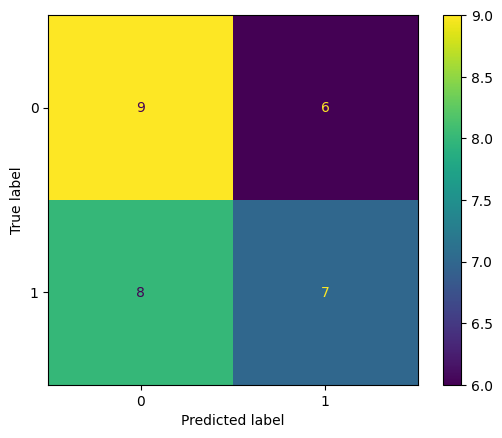

In [ ]:
model_SVC= SVC()
model_SVC.fit(x_train,y_train)
model_pred = model_SVC.predict(x_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_SVC.classes_)
disp.plot()
print(classification_report(y_test,model_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, model_SVC, new_X, y)

precision :  0.6 
 recall : 0.5294117647058824 
 f1_score : 0.5625
for fold: 2, accuracy is: 0.39200680272108845
for fold: 3, accuracy is: 0.4131944444444444
for fold: 4, accuracy is: 0.42125
for fold: 5, accuracy is: 0.4026315789473684
for fold: 6, accuracy is: 0.44178921568627455
for fold: 7, accuracy is: 0.5149136577708006
for fold: 8, accuracy is: 0.421474358974359
for fold: 9, accuracy is: 0.43131313131313126
for fold: 10, accuracy is: 0.45111111111111113
Best fit
7 gives accuracy of 0.5149136577708006


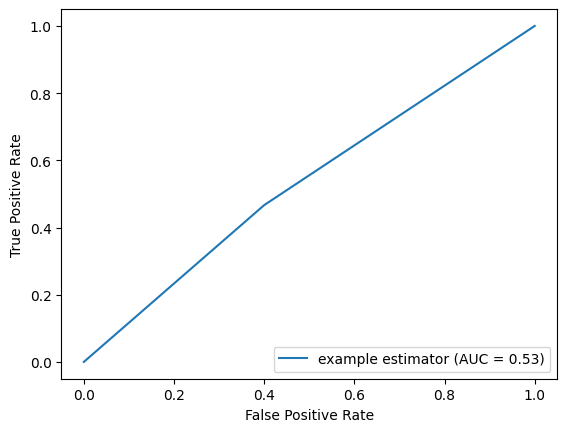

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, model_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## Naive Bayes

[[10  5]
 [13  2]]


              precision    recall  f1-score   support

           0       0.43      0.67      0.53        15
           1       0.29      0.13      0.18        15

    accuracy                           0.40        30
   macro avg       0.36      0.40      0.35        30
weighted avg       0.36      0.40      0.35        30



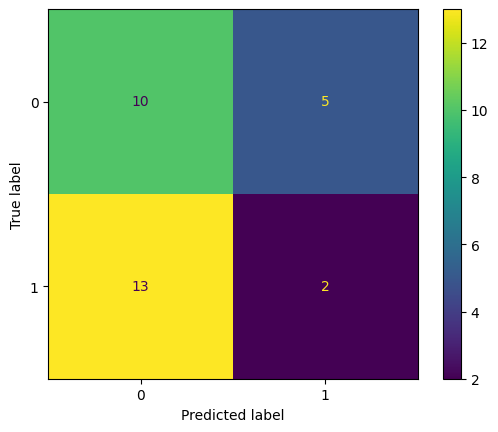

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_test,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_X, y)

precision :  0.6666666666666666 
 recall : 0.43478260869565216 
 f1_score : 0.5263157894736841
for fold: 2, accuracy is: 0.5569727891156463
for fold: 3, accuracy is: 0.48358585858585856
for fold: 4, accuracy is: 0.4945833333333333
for fold: 5, accuracy is: 0.493157894736842
for fold: 6, accuracy is: 0.4950980392156863
for fold: 7, accuracy is: 0.49450549450549447
for fold: 8, accuracy is: 0.4855769230769231
for fold: 9, accuracy is: 0.48181818181818176
for fold: 10, accuracy is: 0.4811111111111111
Best fit
2 gives accuracy of 0.5569727891156463


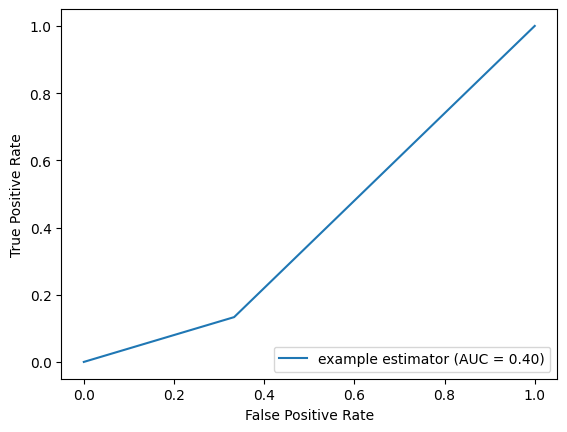

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## DT

[[8 7]
 [9 6]]


              precision    recall  f1-score   support

           0       0.47      0.53      0.50        15
           1       0.46      0.40      0.43        15

    accuracy                           0.47        30
   macro avg       0.47      0.47      0.46        30
weighted avg       0.47      0.47      0.46        30



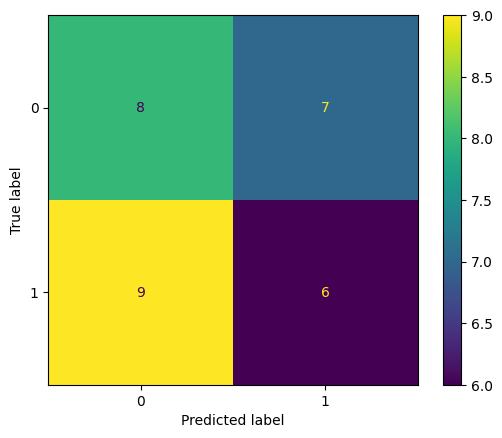

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)
cm = confusion_matrix(y_test,dt_pred)
print(cm)
print('\n')
print(classification_report(y_test,dt_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, dt, new_X, y)

precision :  0.5333333333333333 
 recall : 0.47058823529411764 
 f1_score : 0.5


for fold: 2, accuracy is: 0.5973639455782312
for fold: 3, accuracy is: 0.7626262626262627
for fold: 4, accuracy is: 0.64
for fold: 5, accuracy is: 0.5578947368421053
for fold: 6, accuracy is: 0.6078431372549019
for fold: 7, accuracy is: 0.5965463108320251
for fold: 8, accuracy is: 0.5977564102564104
for fold: 9, accuracy is: 0.5767676767676767
for fold: 10, accuracy is: 0.5988888888888888
Best fit
3 gives accuracy of 0.7626262626262627


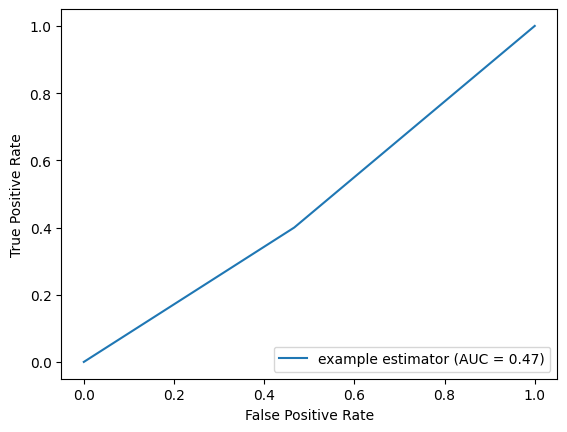

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, dt_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## LDA

[[8 7]
 [9 6]]


              precision    recall  f1-score   support

           0       0.56      0.67      0.61        15
           1       0.58      0.47      0.52        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.56        30
weighted avg       0.57      0.57      0.56        30



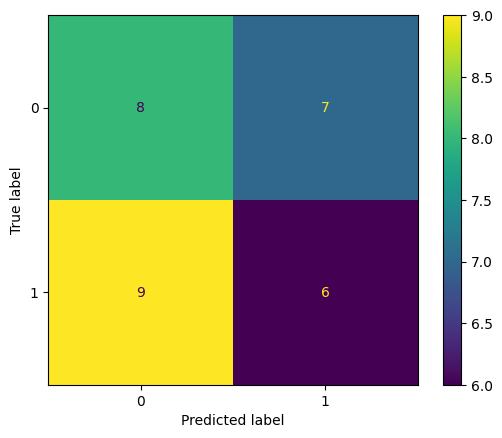

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_test)
confusion_matrix(y_test,lda_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print('\n')
print(classification_report(y_test,lda_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

#Kfold
acc = k_evaluate(10,lda, new_X, y)  # here k 10

precision :  0.6666666666666666 
 recall : 0.5555555555555556 
 f1_score : 0.606060606060606
for fold: 2, accuracy is: 0.6075680272108843
for fold: 3, accuracy is: 0.5574494949494949
for fold: 4, accuracy is: 0.6183333333333334
for fold: 5, accuracy is: 0.5873684210526317
for fold: 6, accuracy is: 0.6488970588235294
for fold: 7, accuracy is: 0.6271585557299842
for fold: 8, accuracy is: 0.6169871794871795
for fold: 9, accuracy is: 0.604040404040404
for fold: 10, accuracy is: 0.6277777777777778
Best fit
6 gives accuracy of 0.6488970588235294


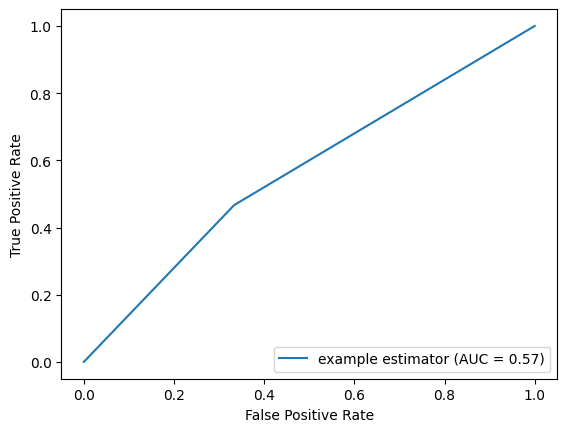

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, lda_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## Random Forest

[[9 6]
 [8 7]]


              precision    recall  f1-score   support

           0       0.53      0.60      0.56        15
           1       0.54      0.47      0.50        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



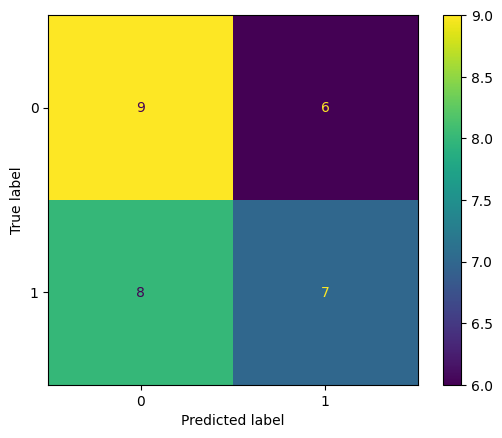

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
rf_pred = rf_classifier.predict(x_test)


cm = confusion_matrix(y_test,rf_pred)
print(cm)
print('\n')
print(classification_report(y_test,rf_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, rf_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier,new_X, y)

precision :  0.6 
 recall : 0.5294117647058824 
 f1_score : 0.5625


for fold: 2, accuracy is: 0.5765306122448979
for fold: 3, accuracy is: 0.6802398989898991
for fold: 4, accuracy is: 0.67
for fold: 5, accuracy is: 0.5873684210526315
for fold: 6, accuracy is: 0.6072303921568628
for fold: 7, accuracy is: 0.6789638932496075
for fold: 8, accuracy is: 0.5857371794871795
for fold: 9, accuracy is: 0.593939393939394
for fold: 10, accuracy is: 0.6900000000000002
Best fit
10 gives accuracy of 0.6900000000000002


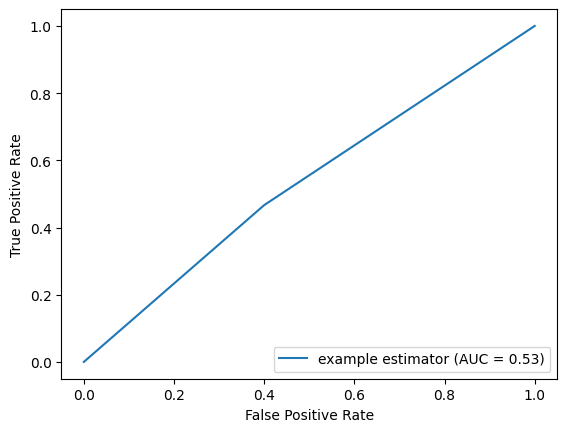

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()